In [283]:
import geopandas as gp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython
import geodatasets
from shapely import box
from shapely.geometry import Polygon,box,Point
import rasterio
from rasterio.plot import show
from scipy.ndimage import gaussian_filter

# 1. Crear grilla

In [284]:
# Importar mapa

biobio = gp.read_file(r'C:\Users\joaci\OneDrive - Universidad de Chile\XII Semestre\Proyecto de ciencia de datos\Datos\mapa biobio\biobio_geodf.shp')

biobio = biobio.to_crs(epsg=32718) # coordenadas de distancia en metros

# límites de la región 
xmin, ymin, xmax, ymax = biobio.total_bounds

def create_grid(cell_width = 3000, cell_height = 3000):
    # Crear una lista para almacenar las celdas de la cuadrícula
    grid_cells = []

    # Iterar sobre las coordenadas para crear las celdas de la cuadrícula
    for x0 in np.arange(xmin, xmax, cell_width):
        for y0 in np.arange(ymin, ymax, cell_height):
            x1 = x0 + cell_width
            y1 = y0 + cell_height
            new_cell = box(x0, y0, x1, y1)
            grid_cells.append(new_cell)

    # Crear un GeoDataFrame con las celdas de la cuadrícula
    cell_df = gp.GeoDataFrame(grid_cells, columns=['geometry'], crs=biobio.crs)

    # Filtrar las celdas que intersectan con la región original
    intersects = cell_df['geometry'].intersects(biobio.unary_union)
    cell_df = cell_df[intersects]

    # guardar el archivo con nombre en función de la resolución de la cuadrícula

    cell_df.to_file(r'C:\Users\joaci\OneDrive - Universidad de Chile\XII Semestre\Proyecto de ciencia de datos\Datos\mapa biobio\biobio_grid_' + str(cell_width) + r'_' + str(cell_height) + r'.shp')

    return cell_df

# 2. Variables invariantes en el tiempo

## 2.1 Vegetación

In [285]:
# importar vegetación

vegetacion = gp.read_file(r'C:\Users\joaci\OneDrive - Universidad de Chile\XII Semestre\Proyecto de ciencia de datos\Datos\land cover\land_cover.shp')
vegetacion.crs="EPSG: 32718"
cell_df = create_grid(cell_width = 3000, cell_height = 3000)
cell_df.reset_index(inplace=True, drop=True)
cell_df['cuadrilla'] = cell_df.index
cell_df=cell_df.to_crs(epsg=32718)


Text(0.5, 1.0, 'Cuadrícula de 3km x 3km')

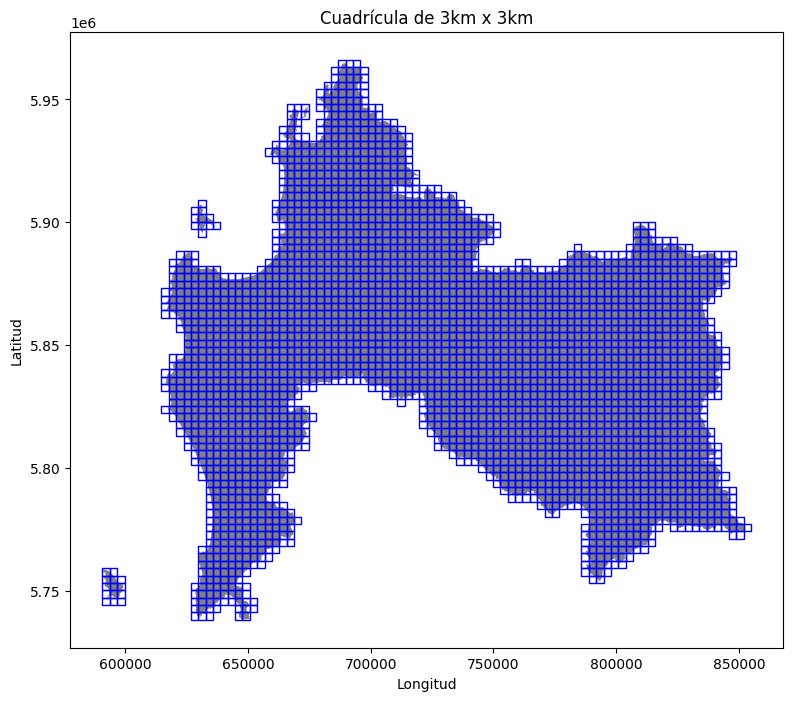

In [286]:
# graficar geometrías

fig, ax = plt.subplots(figsize=(12, 8))

biobio.plot(ax=ax, facecolor='gray');

cell_df.plot(ax=ax, facecolor='none', edgecolor='blue');

plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Cuadrícula de 3km x 3km')



In [287]:
vegetacion['cuadrilla'] = vegetacion.index

joined_data = pd.merge(cell_df, vegetacion, on='cuadrilla', how='left')


In [288]:
joined_data.drop(columns=['geometry_y'], inplace=True)
joined_data.rename(columns={'geometry_x':'geometry'}, inplace=True)

In [289]:
joined_data

,geometry,cuadrilla,vegetation,bosque_nat,bosque_pro,pastizales,matorrales,humedales,cuerpos_ag,superficie,tierras_de
0,"POLYGON ((593787.869 5744181.299, 593787.869 5...",0,1500,0,0,0,0,0,0,0,0
1,"POLYGON ((593787.869 5747181.299, 593787.869 5...",1,1500,0,0,0,0,0,0,0,0
2,"POLYGON ((593787.869 5750181.299, 593787.869 5...",2,480,0,0,0,0,1,0,0,0
3,"POLYGON ((593787.869 5753181.299, 593787.869 5...",3,420,0,0,0,1,0,0,0,0
4,"POLYGON ((593787.869 5756181.299, 593787.869 5...",4,1500,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2954,"POLYGON ((848787.869 5885181.299, 848787.869 5...",2954,1500,0,0,0,0,0,0,0,0
2955,"POLYGON ((851787.869 5771181.299, 851787.869 5...",2955,1500,0,0,0,0,0,0,0,0
2956,"POLYGON ((851787.869 5774181.299, 851787.869 5...",2956,577,0,0,0,0,0,1,0,0
2957,"POLYGON ((851787.869 5777181.299, 851787.869 5...",2957,1500,0,0,0,0,0,0,0,0


<Axes: >

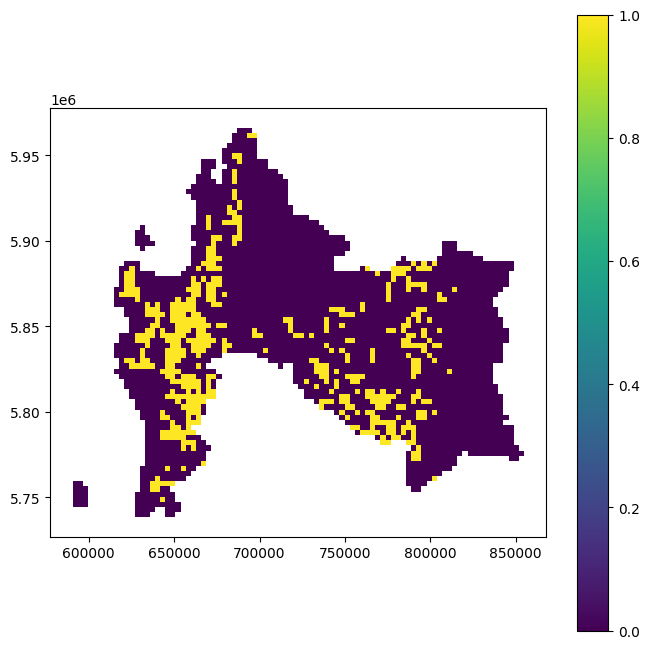

In [290]:
joined_data.plot(column='bosque_pro', legend=True, figsize=(8, 8))

In [291]:
# joined_data = gp.sjoin(cell_df, vegetacion, how="left", predicate="intersects")

# # por cada cuadrilla, calcular el promedio de vegetation y sumar los valores de bosque_nat, bosque_pro, pastizales, matorrales, humedales, cuerpos ag, superficie, tierras_de

# joined_data['vegetation'] = joined_data['vegetation'].astype(float)
# joined_data['bosque_nat'] = joined_data['bosque_nat'].astype(float)
# joined_data['bosque_pro'] = joined_data['bosque_pro'].astype(float)
# joined_data['pastizales'] = joined_data['pastizales'].astype(float)
# joined_data['matorrales'] = joined_data['matorrales'].astype(float)
# joined_data['humedales'] = joined_data['humedales'].astype(float)
# joined_data['cuerpos_ag'] = joined_data['cuerpos_ag'].astype(float)
# joined_data['superficie'] = joined_data['superficie'].astype(float)
# joined_data['tierras_de'] = joined_data['tierras_de'].astype(float)

# joined_data['vegetation_mean'] = joined_data.groupby('cuadrilla')['vegetation'].transform('mean')
# joined_data['bosque_nat_sum'] = joined_data.groupby('cuadrilla')['bosque_nat'].transform('mean')
# joined_data['bosque_pro_sum'] = joined_data.groupby('cuadrilla')['bosque_pro'].transform('mean')
# joined_data['pastizales_sum'] = joined_data.groupby('cuadrilla')['pastizales'].transform('mean')
# joined_data['matorrales_sum'] = joined_data.groupby('cuadrilla')['matorrales'].transform('mean')
# joined_data['humedales_sum'] = joined_data.groupby('cuadrilla')['humedales'].transform('mean')
# joined_data['cuerpos_ag_sum'] = joined_data.groupby('cuadrilla')['cuerpos_ag'].transform('mean')
# joined_data['superficie_sum'] = joined_data.groupby('cuadrilla')['superficie'].transform('mean')
# joined_data['tierras_de_sum'] = joined_data.groupby('cuadrilla')['tierras_de'].transform('mean')

# joined_data['vegetation_mean'] = joined_data['vegetation_mean'].round(2)

# joined_data = joined_data.drop_duplicates(subset=['cuadrilla'])

# joined_data = joined_data[['cuadrilla', 'geometry', 'vegetation_mean', 'bosque_nat_sum', 'bosque_pro_sum', 'pastizales_sum', 'matorrales_sum', 'humedales_sum', 'cuerpos_ag_sum', 'superficie_sum', 'tierras_de_sum']]

# # cambiar nombres por los originales

# joined_data = joined_data.rename(columns={'vegetation_mean': 'vegetation', 'bosque_nat_sum': 'bosque_nat', 'bosque_pro_sum': 'bosque_pro', 'pastizales_sum': 'pastizales', 'matorrales_sum': 'matorrales', 'humedales_sum': 'humedales', 'cuerpos_ag_sum': 'cuerpos_ag', 'superficie_sum': 'superficie', 'tierras_de_sum': 'tierras_de'})

# # para cada valor de bosque_nat, bosque_pro, pastizales, matorrales, humedales, cuerpos_ag, superficie, tierras_de, si es mayor a 0.5, cambiar a 1, si es menor a 0.5, cambiar a 0	

# joined_data['bosque_nat'] = np.where(joined_data['bosque_nat'] > 0.5, 1, 0)
# joined_data['bosque_pro'] = np.where(joined_data['bosque_pro'] > 0.5, 1, 0)
# joined_data['pastizales'] = np.where(joined_data['pastizales'] > 0.5, 1, 0)
# joined_data['matorrales'] = np.where(joined_data['matorrales'] > 0.5, 1, 0)
# joined_data['humedales'] = np.where(joined_data['humedales'] > 0.5, 1, 0)
# joined_data['cuerpos_ag'] = np.where(joined_data['cuerpos_ag'] > 0.5, 1, 0)
# joined_data['superficie'] = np.where(joined_data['superficie'] > 0.5, 1, 0)
# joined_data['tierras_de'] = np.where(joined_data['tierras_de'] > 0.5, 1, 0)

# joined_data

In [292]:
cell_df = joined_data

## 2.2 Factores antropogénicos 

In [293]:
## RED VIAL
red_vial = gp.read_file(r'C:\Users\joaci\OneDrive - Universidad de Chile\XII Semestre\Proyecto de ciencia de datos\Proyecto\modelo_v2\Red_Vial\redvialbiobio.shp')
red_vial = red_vial.to_crs('EPSG:32718')

#RED HIDROGRÁFICA
red_hidro = gp.read_file(r'C:\Users\joaci\OneDrive - Universidad de Chile\XII Semestre\Proyecto de ciencia de datos\Proyecto\modelo_v2\Red_Hidrografica\Red_Hidrografica_biobio.shp')
red_hidro = red_hidro.to_crs('EPSG:32718')

#RED ELECTRICA
red_electrica_gp = gp.read_file(r'C:\Users\joaci\OneDrive - Universidad de Chile\XII Semestre\Proyecto de ciencia de datos\Proyecto\modelo_v2\biobio_con_red.dxf')
red_electrica = gp.GeoDataFrame(red_electrica_gp, geometry='geometry', crs='EPSG:4326')
red_electrica = red_electrica.to_crs('EPSG:32718')

#AREA URBANA
area_urbana = gp.read_file(r'C:\Users\joaci\OneDrive - Universidad de Chile\XII Semestre\Proyecto de ciencia de datos\Proyecto\modelo_v2\Area_Urbana\area_urbana_biobio.shp')
area_urbana = area_urbana.to_crs('EPSG:32718')

In [294]:
import geopandas as gpd
from shapely.geometry import Point

cell_df2 = cell_df.copy()

# transformar a gdf

#cell_df2 = cell_df2.drop(['centro'], axis=1)

#cell_df2['geometry'] = cell_df2['geometry'].apply(loads)

cell_df2 = gp.GeoDataFrame(cell_df2, geometry='geometry')

cell_df2['centro'] = cell_df2['geometry'].apply(lambda x: x.centroid)

# Crear objetos Point a partir de la columna 'centro'
cell_df2['centro_geom'] = cell_df2.apply(lambda row: Point(row['centro']), axis=1)
cell_df2_geo = gpd.GeoDataFrame(cell_df2, geometry='centro_geom').set_crs('EPSG:32718')

# Proyectar puntos de referencia (columna 'centro_geom')
cell_df2_geo = cell_df2_geo.to_crs(red_vial.crs)

def calcular_distancia_a_red(row, red_gdf):
    centro = row['centro_geom']
    # Calcula la distancia mínima entre el centro de la celda y cada línea en la red
    distancias = red_gdf['geometry'].distance(centro)
    # Devuelve la distancia mínima
    return distancias.min()

# Aplicar la función a cada fila y crear una nueva columna 'distancia_a_red_vial' en cell_df2_geo
cell_df2_geo['distancia_a_red_vial'] = cell_df2_geo.apply(calcular_distancia_a_red, args=(red_vial,), axis=1)
cell_df2_geo['distancia_a_red_hidro'] = cell_df2_geo.apply(calcular_distancia_a_red, args=(red_hidro,), axis=1)
cell_df2_geo['distancia_a_red_electrica'] = cell_df2_geo.apply(calcular_distancia_a_red, args=(red_electrica,), axis=1)
cell_df2_geo['distancia_a_area_urbana'] = cell_df2_geo.apply(calcular_distancia_a_red, args=(area_urbana,), axis=1)


c:\Users\joaci\anaconda3\envs\envU\Lib\site-packages\shapely\measurement.py:74: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


In [295]:
cell_df2_geo

,geometry,cuadrilla,vegetation,bosque_nat,bosque_pro,pastizales,matorrales,humedales,cuerpos_ag,superficie,tierras_de,centro,centro_geom,distancia_a_red_vial,distancia_a_red_hidro,distancia_a_red_electrica,distancia_a_area_urbana
0,"POLYGON ((593787.869 5744181.299, 593787.869 5...",0,1500,0,0,0,0,0,0,0,0,POINT (592287.869 5745681.299),POINT (592287.869 5745681.299),2396.263833,36622.871880,40962.548384,10123.192195
1,"POLYGON ((593787.869 5747181.299, 593787.869 5...",1,1500,0,0,0,0,0,0,0,0,POINT (592287.869 5748681.299),POINT (592287.869 5748681.299),1129.550948,36615.136410,40252.179827,7276.877047
2,"POLYGON ((593787.869 5750181.299, 593787.869 5...",2,480,0,0,0,0,1,0,0,0,POINT (592287.869 5751681.299),POINT (592287.869 5751681.299),291.270957,36777.157903,39749.998702,4628.915520
3,"POLYGON ((593787.869 5753181.299, 593787.869 5...",3,420,0,0,0,1,0,0,0,0,POINT (592287.869 5754681.299),POINT (592287.869 5754681.299),28.035677,37149.951166,39463.193436,2550.959718
4,"POLYGON ((593787.869 5756181.299, 593787.869 5...",4,1500,0,0,0,0,0,0,0,0,POINT (592287.869 5757681.299),POINT (592287.869 5757681.299),690.237665,37568.306705,39395.988581,2663.582415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2954,"POLYGON ((848787.869 5885181.299, 848787.869 5...",2954,1500,0,0,0,0,0,0,0,0,POINT (847287.869 5886681.299),POINT (847287.869 5886681.299),36613.234313,5808.674921,36664.633866,56671.157287
2955,"POLYGON ((851787.869 5771181.299, 851787.869 5...",2955,1500,0,0,0,0,0,0,0,0,POINT (850287.869 5772681.299),POINT (850287.869 5772681.299),31620.882521,2036.909371,41565.310891,99797.790972
2956,"POLYGON ((851787.869 5774181.299, 851787.869 5...",2956,577,0,0,0,0,0,1,0,0,POINT (850287.869 5775681.299),POINT (850287.869 5775681.299),30970.685357,129.360855,40922.665739,98261.533061
2957,"POLYGON ((851787.869 5777181.299, 851787.869 5...",2957,1500,0,0,0,0,0,0,0,0,POINT (850287.869 5778681.299),POINT (850287.869 5778681.299),30602.066786,2921.263836,40485.905817,96793.897927


In [296]:
#exportar a csv

cell_df2_geo.to_csv(r'C:\Users\joaci\OneDrive - Universidad de Chile\XII Semestre\Proyecto de ciencia de datos\Proyecto\modelo_v2\grillas_3_3_distancia.csv')

## 2.3 Altura

In [297]:
# agregar elevacion a df_cuadrillas

altura = pd.read_csv(r'C:\Users\joaci\OneDrive - Universidad de Chile\XII Semestre\Proyecto de ciencia de datos\Repo\Proyecto_Arauco\Biobio_topo\altura50000.csv')

# cambiar nan por 0
altura = altura.fillna(0)

In [298]:
# crear un gdf a partir de lat y lon de altura

from shapely import wkt

altura['geometry'] = altura.apply(lambda x: Point((float(x.lon), float(x.lat))), axis=1)

# transformar a EPSG:32718

altura = gp.GeoDataFrame(altura, geometry='geometry')

altura = altura.set_crs('EPSG:4326')

altura = altura.to_crs('EPSG:32718')

altura.drop(['lat', 'lon'], axis=1, inplace=True)

altura['x'] = altura['geometry'].apply(lambda p: p.x)
altura['y'] = altura['geometry'].apply(lambda p: p.y)

altura

,fid,altura,geometry,x,y
0,1,795.0,POINT (799496.405 5788104.609),799496.405135,5.788105e+06
1,2,422.0,POINT (776252.633 5816835.706),776252.633051,5.816836e+06
2,3,1979.0,POINT (831997.761 5876671.650),831997.760568,5.876672e+06
3,4,84.0,POINT (647821.699 5867057.194),647821.699304,5.867057e+06
4,5,1764.0,POINT (815374.827 5884265.638),815374.827251,5.884266e+06
...,...,...,...,...,...
49995,49996,1351.0,POINT (811933.498 5839655.979),811933.498046,5.839656e+06
49996,49997,828.0,POINT (659885.962 5843428.742),659885.961988,5.843429e+06
49997,49998,329.0,POINT (678744.612 5857098.042),678744.611790,5.857098e+06
49998,49999,1070.0,POINT (788646.208 5798818.493),788646.208445,5.798818e+06


In [299]:
from scipy.spatial import cKDTree

# Crea un árbol KD a partir del DataFrame 'altura' para buscar puntos cercanos rápidamente
altura_tree = cKDTree(altura[['x', 'y']].values)

def find_altura(row):
    # Busca el punto más cercano en el árbol KD
    dist, idx = altura_tree.query([row['centro_geom'].x, row['centro_geom'].y])
    # Devuelve el valor de elevación correspondiente
    return altura.iloc[idx]['altura']

df_output = cell_df2_geo.copy()

# Aplica la función a cada fila y crea una nueva columna 'altura'

df_output['altura'] = df_output.apply(find_altura, axis=1)

df_output

,geometry,cuadrilla,vegetation,bosque_nat,bosque_pro,pastizales,matorrales,humedales,cuerpos_ag,superficie,tierras_de,centro,centro_geom,distancia_a_red_vial,distancia_a_red_hidro,distancia_a_red_electrica,distancia_a_area_urbana,altura
0,"POLYGON ((593787.869 5744181.299, 593787.869 5...",0,1500,0,0,0,0,0,0,0,0,POINT (592287.869 5745681.299),POINT (592287.869 5745681.299),2396.263833,36622.871880,40962.548384,10123.192195,0.0
1,"POLYGON ((593787.869 5747181.299, 593787.869 5...",1,1500,0,0,0,0,0,0,0,0,POINT (592287.869 5748681.299),POINT (592287.869 5748681.299),1129.550948,36615.136410,40252.179827,7276.877047,0.0
2,"POLYGON ((593787.869 5750181.299, 593787.869 5...",2,480,0,0,0,0,1,0,0,0,POINT (592287.869 5751681.299),POINT (592287.869 5751681.299),291.270957,36777.157903,39749.998702,4628.915520,0.0
3,"POLYGON ((593787.869 5753181.299, 593787.869 5...",3,420,0,0,0,1,0,0,0,0,POINT (592287.869 5754681.299),POINT (592287.869 5754681.299),28.035677,37149.951166,39463.193436,2550.959718,0.0
4,"POLYGON ((593787.869 5756181.299, 593787.869 5...",4,1500,0,0,0,0,0,0,0,0,POINT (592287.869 5757681.299),POINT (592287.869 5757681.299),690.237665,37568.306705,39395.988581,2663.582415,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2954,"POLYGON ((848787.869 5885181.299, 848787.869 5...",2954,1500,0,0,0,0,0,0,0,0,POINT (847287.869 5886681.299),POINT (847287.869 5886681.299),36613.234313,5808.674921,36664.633866,56671.157287,2565.0
2955,"POLYGON ((851787.869 5771181.299, 851787.869 5...",2955,1500,0,0,0,0,0,0,0,0,POINT (850287.869 5772681.299),POINT (850287.869 5772681.299),31620.882521,2036.909371,41565.310891,99797.790972,0.0
2956,"POLYGON ((851787.869 5774181.299, 851787.869 5...",2956,577,0,0,0,0,0,1,0,0,POINT (850287.869 5775681.299),POINT (850287.869 5775681.299),30970.685357,129.360855,40922.665739,98261.533061,1721.0
2957,"POLYGON ((851787.869 5777181.299, 851787.869 5...",2957,1500,0,0,0,0,0,0,0,0,POINT (850287.869 5778681.299),POINT (850287.869 5778681.299),30602.066786,2921.263836,40485.905817,96793.897927,2267.0


# 3. Datos de incendios (Conaf y Arauco)

In [300]:
df_conaf = pd.read_excel(r"C:\Users\joaci\OneDrive - Universidad de Chile\XII Semestre\Proyecto de ciencia de datos\Repo\Proyecto_Arauco\datos_conaf.xlsx")
df_conaf['Point'] = df_conaf.apply(lambda row: Point(row['Lon'], row['Lat']), axis=1)

# transformar punto a EPSG:32718

df_conaf = gp.GeoDataFrame(df_conaf, geometry='Point')

df_conaf = df_conaf.set_crs('EPSG:4326')

df_conaf = df_conaf.to_crs('EPSG:32718')

#cell_df = cell_df.drop(['centro'], axis=1)
#cell_df['geometry'] = cell_df['geometry'].apply(loads)
def find_containing_box(point, boxes):
    for index, box in enumerate(boxes):
        if box.contains(point):
            return index
    return None

df_conaf['Cuadrilla'] = df_conaf['Point'].apply(find_containing_box, args=(cell_df['geometry'],))

df_conaf = df_conaf[df_conaf['Cuadrilla'].notnull()]

df_conaf = df_conaf.drop("Unnamed: 0", axis=1)

In [301]:
from datetime import datetime

# Define un mapeo de nombres de meses a números de mes
meses = {'ene': 'Jan', 'feb': 'Feb', 'mar': 'Mar', 'abr': 'Apr', 'may': 'May', 'jun': 'Jun',
         'jul': 'Jul', 'ago': 'Aug', 'sep': 'Sep', 'oct': 'Oct', 'nov': 'Nov', 'dic': 'Dec'}

# Función para convertir una fecha en formato 'dd-mes-año hora:minuto' a formato datetime
def convertir_a_datetime(fecha_str):
    partes = fecha_str.split('-')
    dia = int(partes[0])
    mes = meses[partes[1].lower()]
    ano = int(partes[2].split()[0])
    hora, minuto = map(int, partes[2].split()[1].split(':'))
    return datetime(ano, datetime.strptime(mes, '%b').month, dia, hora, minuto)

# Aplica la función a la columna 'fecha' y crea una nueva columna 'fecha_datetime'

df_conaf['Inicio'] = df_conaf['Inicio'].apply(convertir_a_datetime)

In [302]:
primer_dia = df_conaf["Inicio"].min().date()
ultimo_dia = df_conaf["Inicio"].max().date()

print("El primer dia es: ", primer_dia)
print("El ultimo dia es: ", ultimo_dia)

El primer dia es:  2018-09-02
El ultimo dia es:  2022-05-31


In [303]:
# crear una columna con el dia de la semana y el dia del año

df_conaf['Dia_de_la_semana'] = df_conaf['Inicio'].dt.day_name(locale='Spanish')

In [304]:
#creacion dia del año
#Funcion que obtiene el dia del año, pero en años bisietos, a partir del 29 de febrero se resta 1

def get_dia_bisiesto(datetime):
    try:
        if datetime.year % 4 == 0 and (datetime.year % 100 != 0 or datetime.year % 400 == 0):
            #if date is after Feb 29th, subtract 1
            if datetime.month > 2 or (datetime.month == 2 and datetime.day == 29):
                return datetime.timetuple().tm_yday - 1
            else:
                return datetime.timetuple().tm_yday
        else:
            return datetime.timetuple().tm_yday
    except:
        return np.nan

df_conaf['Dia_del_año'] = df_conaf['Inicio'].apply(get_dia_bisiesto)

In [305]:
# buscar incendios que se hayan ocurrdo el 29 de febrero

incendios_29_feb = ((df_conaf['Inicio'].dt.month == 2) & (df_conaf['Inicio'].dt.day == 29))

df_conaf.loc[incendios_29_feb, 'Inicio'] = np.where(np.random.rand(sum(incendios_29_feb)) > 0.5,
                                                                    df_conaf.loc[incendios_29_feb, 'Inicio'] + pd.Timedelta(days=1),
                                                                    df_conaf.loc[incendios_29_feb, 'Inicio'] - pd.Timedelta(days=1))
# redefinir el dia de la semana, dia del mes y dia del año
df_conaf.loc[incendios_29_feb, 'Dia_de_la_semana'] = df_conaf.loc[incendios_29_feb, 'Inicio'].dt.day_name(locale = 'Spanish')
df_conaf.loc[incendios_29_feb, 'Dia_del_año'] = df_conaf.loc[incendios_29_feb, 'Inicio'].apply(get_dia_bisiesto)

df_conaf.head()

,Región,Provincia,Comuna,Nombre incendio,UTM E,UTM N,Huso,Causa general,Causa específica,Pino 0 a 10,...,Dirección viento,Velocidad viento,Topografía,Pendiente,Lat,Lon,Point,Cuadrilla,Dia_de_la_semana,Dia_del_año
0,Biobío,Biobio,Nacimiento,TRALPENES Y OTROS,711129 E,5845313 S,18H,Faenas forestales,1.1.22. Otros incendios por faenas forestales ...,0.0,...,S,10.0,NaN,%,-37.515000,-72.611111,POINT (711127.771 5845313.329),1317.0,Lunes,323
1,Biobío,Concepción,Coronel,ESCUADRON,666889 E,5909655 S,18H,Incendios intencionales,2.1.8. Vandalismo (excluidos terrorismo y aten...,0.0,...,S,3.0,NaN,%,-36.944444,-73.125833,POINT (666885.559 5909649.716),721.0,Domingo,322
2,Biobío,Biobio,Quilaco,BRETANA,756360 E,5821179 S,18H,Incendios intencionales,2.1.8. Vandalismo (excluidos terrorismo y aten...,0.0,...,S,5.0,NaN,%,-37.720833,-72.091389,POINT (756361.237 5821175.303),1834.0,Domingo,322
3,Biobío,Concepción,Coronel,ESCUADRON,665097 E,5909157 S,18H,Incendios intencionales,2.1.8. Vandalismo (excluidos terrorismo y aten...,0.0,...,SW,15.0,NaN,%,-36.949167,-73.145833,POINT (665094.285 5909160.635),668.0,Miércoles,318
4,Biobío,Arauco,Cañete,MAQUEHUA,654518 E,5814058 S,18H,Incendios intencionales,2.1.8. Vandalismo (excluidos terrorismo y aten...,0.0,...,N,10.0,NaN,%,-37.807778,-73.244722,POINT (654516.151 5814060.928),510.0,Lunes,344


In [306]:
# del total de incendios, seleccionar los mas recientes y construir un nuevo dataframe de holdout

df_conaf = df_conaf.sort_values(by='Inicio', ascending=False)

# elegir incendios del ultimo año

df_holdout = df_conaf[df_conaf['Inicio'] > '2021-12-31']

# eliminar incendios del ultimo año del dataframe original

df_train = df_conaf[df_conaf['Inicio'] <= '2021-12-31']


In [307]:
# comprobacion de que no hayan filas de holdout en el dataframe de entrenamiento

assert df_train.index.intersection(df_holdout.index).empty 

In [308]:
# guardar df_output en un csv

df_output.to_csv(r'C:\Users\joaci\OneDrive - Universidad de Chile\XII Semestre\Proyecto de ciencia de datos\Proyecto\modelo_v2\grillas_3_3_distancia_vegetacion.csv')

In [309]:
df_0 = df_conaf.copy()
df_1 = df_train.copy()
df_2 = df_holdout.copy()

# tomar las cuadriculas y hacer un dataframe con cada una de ellas
df_cuadrillas = pd.DataFrame(cell_df['geometry'])

# renombrar columna geometry a cuadrilla
df_cuadrillas = df_cuadrillas.rename(columns={'geometry': 'Cuadrilla'})

# asignar un id a cada cuadrilla

df_cuadrillas['id'] = df_cuadrillas.index

#agregar una columna por cada día del año

for i in range(1, 366):
    df_cuadrillas[str(i)] = 0

C:\Users\joaci\AppData\Local\Temp\ipykernel_12128\3904621669.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_cuadrillas[str(i)] = 0
C:\Users\joaci\AppData\Local\Temp\ipykernel_12128\3904621669.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_cuadrillas[str(i)] = 0
C:\Users\joaci\AppData\Local\Temp\ipykernel_12128\3904621669.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once us

In [310]:
# crear funcion para obtener el numero de incendios por cuadrilla y dia del año

def dataframe_incendios(df):
    # asignar 1 si la cuadrilla tiene un incendio en la dia del año correspondiente

    df_output = df_cuadrillas.copy()

    for index, row in df.iterrows():
        df_output.loc[row['Cuadrilla'], str(row['Dia_del_año'])] = 1

    #quitar la columna cuadrilla

    df_output = df_output.drop(columns=['Cuadrilla'])

    combinaciones = [(cuadrilla, dia) for cuadrilla in df_output['id'].unique() for dia in range(1,366)]

    df_extended = pd.DataFrame(combinaciones, columns=['cuadrilla', 'dia'])

    # crear variable incendio si para el id de la cuadrilla, el dia del año es 1

    df_extended['incendio'] = df_extended.apply(lambda row: df_output.iloc[row['cuadrilla'], row['dia']], axis=1)

    return df_extended

df_0 = dataframe_incendios(df_0)
df_1 = dataframe_incendios(df_1)
df_2 = dataframe_incendios(df_2)

In [311]:
from shapely.wkt import loads

# agregar columnas con la latitud y longitud de cada cuadrilla

df_cuadrillas['x'] = df_cuadrillas['Cuadrilla'].apply(lambda x: x.centroid.x)
df_cuadrillas['y'] = df_cuadrillas['Cuadrilla'].apply(lambda x: x.centroid.y)

# asignar un id a cada cuadrilla

df_cuadrillas['id'] = df_cuadrillas.index

#agregar una columna por cada día del año

columns = [str(i) for i in range(1, 366)]
df_cuadrillas = pd.concat([df_cuadrillas, pd.DataFrame(0, index=df_cuadrillas.index, columns=columns)], axis=1)

# quitar la columna cuadrilla

df_cuadrillas = df_cuadrillas.drop(columns=['Cuadrilla'])

combinaciones = [(cuadrilla, dia) for cuadrilla in df_cuadrillas['id'].unique() for dia in range(1,366)]

df_cuadrillas = pd.DataFrame(combinaciones, columns=['cuadrilla', 'dia'])


C:\Users\joaci\AppData\Local\Temp\ipykernel_12128\384807609.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_cuadrillas['x'] = df_cuadrillas['Cuadrilla'].apply(lambda x: x.centroid.x)
C:\Users\joaci\AppData\Local\Temp\ipykernel_12128\384807609.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_cuadrillas['y'] = df_cuadrillas['Cuadrilla'].apply(lambda x: x.centroid.y)


In [312]:
# a cada cuadrilla y dia de df_cuadrillas, agregar los valores de df_output

df_cuadrillas0 = df_cuadrillas.copy()
df_cuadrillas1 = df_cuadrillas.copy()
df_cuadrillas2 = df_cuadrillas.copy()

df_cuadrillas0 = df_cuadrillas0.merge(df_output, how='left', on='cuadrilla')
df_cuadrillas1 = df_cuadrillas1.merge(df_output, how='left', on='cuadrilla')
df_cuadrillas2 = df_cuadrillas2.merge(df_output, how='left', on='cuadrilla')   

In [313]:
# hacer merge df_1 con df_cuadrillas1 y df_2 con df_cuadrillas2

df_00 = df_0.copy()
df_11 = df_1.copy()
df_22 = df_2.copy()

df_00 = df_00.merge(df_cuadrillas0, how='left', left_on=['cuadrilla', 'dia'], right_on=['cuadrilla', 'dia'])
df_11 = df_11.merge(df_cuadrillas1, how='left', left_on=['cuadrilla', 'dia'], right_on=['cuadrilla', 'dia'])
df_22 = df_22.merge(df_cuadrillas2, how='left', left_on=['cuadrilla', 'dia'], right_on=['cuadrilla', 'dia'])

In [314]:
# drop centro y centro_geom

df_00 = df_00.drop(columns=['centro', 'centro_geom'])
df_00['geometry'] = df_00['geometry'].apply(lambda x: x.wkt)
df_00.to_parquet(r'C:\Users\joaci\OneDrive - Universidad de Chile\XII Semestre\Proyecto de ciencia de datos\Proyecto\modelo_v2\df_completo_3_3_sin_clima.parquet')


In [315]:
#drop centro y centro_geom
df_11 = df_11.drop(columns=['centro', 'centro_geom'])
df_11['geometry'] = df_11['geometry'].apply(lambda x: x.wkt)
df_11.to_parquet(r'C:\Users\joaci\OneDrive - Universidad de Chile\XII Semestre\Proyecto de ciencia de datos\Proyecto\modelo_v2\train_3_3_sin_clima.parquet')

In [316]:
# drop centro y centro_geom
df_22 = df_22.drop(columns=['centro', 'centro_geom'])
# guardar df_22 como geoparquet
df_22['geometry'] = df_22['geometry'].apply(lambda x: x.wkt)
df_22.to_parquet(r'C:\Users\joaci\OneDrive - Universidad de Chile\XII Semestre\Proyecto de ciencia de datos\Proyecto\modelo_v2\holdout_3_3_sin_clima.parquet')

In [317]:
df_00[df_00['incendio'] == 1]['dia'].sort_values().unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 124, 126, 127, 129, 130, 131, 132, 133,
       135, 137, 138, 146, 150, 151, 213, 214, 215, 222, 223, 224, 245,
       246, 247, 248, 249, 250, 251, 253, 254, 255, 256, 257, 258, 259,
       261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 274,
       275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 28

# 4. Agregar variables climatológicas (dependientes del tiempo) 

## 4.1 Temperatura media

In [318]:
# Definir una función para verificar si una estación climatológica o de precipitación está dentro del MultiPolygon

def is_within_region(row):
    point = Point(row['x'], row['y'])
    return point.within(biobio.unary_union)

In [319]:
# datos de clima 

clima = pd.read_csv(r'C:\Users\joaci\OneDrive - Universidad de Chile\XII Semestre\Proyecto de ciencia de datos\Repo\Proyecto_Arauco\t_media\cr2_tasDaily_2020_ghcn.txt', sep=",")

#trasponer los datos

clima = clima.T

# asignar primera fila como nombres de columnas

clima.columns = clima.iloc[0]

# eliminar primera fila

clima = clima.iloc[1:]

#agregar indice para que codigo_estacion sea una columna

clima['codigo_estacion'] = clima.index

# cambiar nombre del indice

clima.columns.name = "id"

# resetear el indice

clima = clima.reset_index(drop=True)

# cambiar a epsg:32718

clima['geometry'] = clima.apply(lambda x: Point((float(x.longitud), float(x.latitud))), axis=1)

# transformar a EPSG:32718

clima = gp.GeoDataFrame(clima, geometry='geometry')

clima = clima.set_crs('EPSG:4326')

clima = clima.to_crs('EPSG:32718')

clima.drop(['latitud', 'longitud'], axis=1, inplace=True)

clima['x'] = clima['geometry'].apply(lambda p: p.x)
clima['y'] = clima['geometry'].apply(lambda p: p.y)

# Aplicar la función para filtrar las estaciones dentro del MultiPolygon
clima['is_within_region'] = clima.apply(is_within_region, axis=1)

# Filtrar las estaciones dentro de la región
clima_dentro_region = clima[clima['is_within_region']]

# Eliminar la columna temporal 'is_within_region' si no la necesitas
del clima_dentro_region['is_within_region']


C:\Users\joaci\AppData\Local\Temp\ipykernel_12128\2721840607.py:3: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,25

In [320]:
clima.iloc[:, 0:14]

id,institucion,fuente,nombre,altura,codigo_cuenca,nombre_cuenca,codigo_sub_cuenca,nombre_sub_cuenca,inicio_observaciones,fin_observaciones,cantidad_observaciones,inicio_automatica,1900-01-01,1900-01-02
0,DGA,dga_web,Visviri,4080,10,Altiplanicas,100,Entre Limite Peru-Bolivia Y Rio Lauca,2014-01-01,2020-03-31,2270,2014-01-01,-9999,-9999
1,DGA,dga_web,Rio Caracarani En Humapalca,3908,12,Rio Lluta,120,Rio Lluta Alto,2016-09-01,2020-03-31,533,2016-09-01,-9999,-9999
2,DGA,dga_web,Caquena,4400,10,Altiplanicas,100,Entre Limite Peru-Bolivia Y Rio Lauca,1976-10-04,1993-09-30,4072,-,-9999,-9999
3,DGA,dga_web,Pacollo,4185,12,Rio Lluta,120,Rio Lluta Alto,1978-11-20,1994-01-02,4779,-,-9999,-9999
4,DGA,dga_web,Putre (Dcp),3560,12,Rio Lluta,120,Rio Lluta Alto,2002-01-17,2020-03-31,2545,2016-09-01,-9999,-9999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,GHCN,ghcn_ftp,Theresa,1463,NaN,NaN,NaN,NaN,1997-01-01,2020-03-29,7306,-,-9999,-9999
896,GHCN,ghcn_ftp,Thiel Mtns Aws,1634,NaN,NaN,NaN,NaN,2009-01-13,2016-02-17,1003,-,-9999,-9999
897,GHCN,ghcn_ftp,Nico,2935,NaN,NaN,NaN,NaN,1994-06-01,2020-03-29,6619,-,-9999,-9999
898,GHCN,ghcn_ftp,Henry,2755,NaN,NaN,NaN,NaN,1994-06-01,2020-03-29,6815,-,-9999,-9999


In [321]:
import numpy as np

# quitar todas las columnas que tengan una fecha menor a 2018

clima_dentro_region_2 = clima_dentro_region.copy()

clima_dentro_region_2 = clima_dentro_region_2.drop(clima_dentro_region_2.columns[clima_dentro_region_2.columns < '2017-01-01'], axis=1)

# reemplazar -9999 por NaN

clima_dentro_region_2 = clima_dentro_region_2.replace(-9999, np.nan)

# interpolacion lineal

clima_var = clima_dentro_region_2.iloc[:, 0:12]

clima_fecha = clima_dentro_region_2.iloc[:, 14:-4]

clima_coord = clima_dentro_region_2.iloc[:, -2:]

clima_fecha.columns = pd.to_datetime(clima_fecha.columns)

clima_fecha = clima_fecha.interpolate(method='linear', axis=1)

# eliminar columnas con datos faltantes

clima_fecha = clima_fecha[clima_fecha.isnull().sum(axis=1) < 10]

# aplicar funcion dayofyear y cambiar nombre de columnas

clima_fecha = clima_fecha.rename(columns=lambda x: x.dayofyear)

# agrupar columnas con el mismo dia del año

clima_fecha = clima_fecha.T.groupby(level=0).mean().T

# hacer left join con clima_var

clima_dentro_region_3 = pd.concat([clima_var, clima_coord, clima_fecha], axis=1, join='inner')

In [322]:
# llamar a cell_df2_geo

cell_df2_geo = pd.read_csv(r'C:\Users\joaci\OneDrive - Universidad de Chile\XII Semestre\Proyecto de ciencia de datos\Proyecto\modelo_v2\grillas_3_3_distancia_vegetacion.csv')
cell_df2_geo = cell_df2_geo.drop(columns=['Unnamed: 0'])


In [323]:
# agregar clima a df_cuadrillas_clima
df_cuadrillas_clima = df_cuadrillas.copy()

# buscar el centro de cada cuadrilla y asignar latitud y longitud
df_cuadrillas_clima['x'] = df_cuadrillas_clima.apply(lambda row: cell_df.loc[row['cuadrilla'], 'geometry'].centroid.x, axis=1)
df_cuadrillas_clima['y'] = df_cuadrillas_clima.apply(lambda row: cell_df.loc[row['cuadrilla'], 'geometry'].centroid.y, axis=1)



In [324]:
from scipy.spatial.distance import cdist

# Supongamos que ya tienes df_cuadrillas_clima, clima_var y clima_fecha cargados

# Verifica y convierte el tipo de datos en las columnas de latitud y longitud
df_cuadrillas_clima[['x', 'y']] = df_cuadrillas_clima[['x', 'y']].astype(float)
clima_dentro_region_3[['x', 'y']] = clima_dentro_region_3[['x', 'y']].astype(float)

# Asegúrate de que las columnas necesarias estén presentes en ambos DataFrames
coordenadas_cuadrilla = df_cuadrillas_clima[['x', 'y']].values
coordenadas_estacion = clima_dentro_region_3[['x', 'y']].values

# Calcula la matriz de distancias entre todas las cuadrículas y estaciones meteorológicas
distancias = cdist(coordenadas_cuadrilla, coordenadas_estacion)

# Encuentra el índice de la estación más cercana para cada cuadrícula
indices_estacion_cercana = np.argmin(distancias, axis=1)

# Asigna el nombre de la estación más cercana a cada cuadrícula
df_cuadrillas_clima['nombre'] = clima_dentro_region_3['nombre'].iloc[indices_estacion_cercana].values



In [325]:
# guardar df_cuadrillas_clima como parquet

df_cuadrillas_clima.to_parquet(r'C:\Users\joaci\OneDrive - Universidad de Chile\XII Semestre\Proyecto de ciencia de datos\Proyecto\modelo_v2\grillas_3_3_estacion_mas_cercana_tprom.parquet')

In [326]:
# agregar clima a df_output

df_output = df_cuadrillas_clima.copy() # df_cuadrillas_clima es df_cuadrillas pero con los nombres ya asignados

# buscar el centro de cada cuadrilla y asignar latitud y longitud
t_prom = clima_fecha.copy()

t_prom = pd.concat([clima_var['nombre'], clima_fecha], axis=1, join='inner')

for row in df_output.itertuples():
    df_output.at[row.Index, 't_prom'] = t_prom.loc[t_prom['nombre'] == row.nombre, row.dia].values[0]

In [327]:
df_output

,cuadrilla,dia,x,y,nombre,t_prom
0,0,1,592287.868735,5.745681e+06,Maria Dolores Los Angeles Ad.,19.533333
1,0,2,592287.868735,5.745681e+06,Maria Dolores Los Angeles Ad.,18.900000
2,0,3,592287.868735,5.745681e+06,Maria Dolores Los Angeles Ad.,18.175000
3,0,4,592287.868735,5.745681e+06,Maria Dolores Los Angeles Ad.,19.000000
4,0,5,592287.868735,5.745681e+06,Maria Dolores Los Angeles Ad.,17.825000
...,...,...,...,...,...,...
1080030,2958,361,853287.868735,5.775681e+06,Embalse Ralco,7.566667
1080031,2958,362,853287.868735,5.775681e+06,Embalse Ralco,7.672333
1080032,2958,363,853287.868735,5.775681e+06,Embalse Ralco,7.637667
1080033,2958,364,853287.868735,5.775681e+06,Embalse Ralco,7.093000


In [328]:
# exportar df_output como parquet

df_output.to_parquet(r'C:\Users\joaci\OneDrive - Universidad de Chile\XII Semestre\Proyecto de ciencia de datos\Proyecto\modelo_v2\grillas_3_3_tprom.parquet')

## 4.2 Precipitaciones

In [329]:
#trasponer los datos
precipitaciones = pd.read_csv(r'C:\Users\joaci\OneDrive - Universidad de Chile\XII Semestre\Proyecto de ciencia de datos\Repo\Proyecto_Arauco\pr_media\cr2_prDaily_2020_ghcn.txt', sep=",")

precipitaciones = precipitaciones.T

# asignar primera fila como nombres de columnas

precipitaciones.columns = precipitaciones.iloc[0]

# eliminar primera fila

precipitaciones = precipitaciones.iloc[1:]

#agregar indice para que codigo_estacion sea una columna

precipitaciones['codigo_estacion'] = precipitaciones.index

# cambiar nombre del indice

precipitaciones.columns.name = "id"

# resetear el indice

precipitaciones.reset_index(drop=True, inplace=True)

# cambiar a epsg:32718

precipitaciones['geometry'] = precipitaciones.apply(lambda x: Point((float(x.longitud), float(x.latitud))), axis=1)

# transformar a EPSG:32718

precipitaciones = gp.GeoDataFrame(precipitaciones, geometry='geometry')

precipitaciones = precipitaciones.set_crs('EPSG:4326')

precipitaciones = precipitaciones.to_crs('EPSG:32718')

precipitaciones.drop(['latitud', 'longitud'], axis=1, inplace=True)

precipitaciones['x'] = precipitaciones['geometry'].apply(lambda p: p.x)
precipitaciones['y'] = precipitaciones['geometry'].apply(lambda p: p.y)

precipitaciones['is_within_region'] = precipitaciones.apply(is_within_region, axis=1)

# Filtrar las estaciones dentro de la región
precipitaciones_dentro_region = precipitaciones[precipitaciones['is_within_region']]

# Eliminar la columna temporal 'is_within_region' si no la necesitas
del precipitaciones_dentro_region['is_within_region']

#display(clima_dentro_region)

# quitar todas las columnas que tengan una fecha menor a 2018

precipitaciones_dentro_region_2 = precipitaciones_dentro_region.drop(precipitaciones_dentro_region.columns[precipitaciones_dentro_region.columns < '2015-01-01'], axis=1)

precipitaciones_dentro_region = precipitaciones_dentro_region.drop(precipitaciones_dentro_region.columns[precipitaciones_dentro_region.columns < '2018-09-02'], axis=1)

# reemplazar -9999 por NaN

precipitaciones_dentro_region = precipitaciones_dentro_region.replace(-9999, np.nan)

# buscar NAs por fila

precipitaciones_dentro_region.isnull().sum(axis=1)

precipitaciones_dentro_region = precipitaciones_dentro_region[precipitaciones_dentro_region.isnull().sum(axis=1) < 10]

#precipitaciones_dentro_region = precipitaciones_dentro_region.drop("inicio_automatica",axis=1)

precipitaciones_var = precipitaciones_dentro_region.iloc[:, 1:12]

precipitaciones_fecha = precipitaciones_dentro_region.iloc[:, 12:-4]

precipitaciones_coord = precipitaciones_dentro_region.iloc[:, -2:]

precipitaciones_fecha.columns = pd.to_datetime(precipitaciones_fecha.columns)

precipitaciones_fecha = precipitaciones_fecha.interpolate(method='linear', axis=1)

precipitaciones_fecha = precipitaciones_fecha[precipitaciones_fecha.isnull().sum(axis=1) < 10]

precipitaciones_fecha = precipitaciones_fecha.rename(columns=lambda x: x.dayofyear)

precipitaciones_fecha = precipitaciones_fecha.groupby(precipitaciones_fecha.columns, axis=1).mean()

precipitaciones_dentro_region_final = pd.concat([precipitaciones_var, precipitaciones_coord, precipitaciones_fecha], axis=1, join='inner')

precipitaciones_dentro_region_final


C:\Users\joaci\AppData\Local\Temp\ipykernel_12128\747010476.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255

id,fuente,nombre,altura,codigo_cuenca,nombre_cuenca,codigo_sub_cuenca,nombre_sub_cuenca,inicio_observaciones,fin_observaciones,cantidad_observaciones,...,356,357,358,359,360,361,362,363,364,365
514,dga_web,Estero Bellavista En Tom,7,82,Costeras E Islas Entre Rio Itata Y Rio Bio-Bio,821,Costeras Entre Rio Pingueral Y Rio Andalien,2009-06-01,2020-03-31,3598,...,0.0,0.00,0.400,0.0,0.0,0.0,0.0,1.20,0.05,0.0
543,dga_web,Rio Laja Ag.Arr. Del Salto (Rec.R.Laja),140,83,Rio Bio-Bio,838,Laja Bajo,2009-05-06,2020-03-31,3192,...,0.0,0.00,0.050,0.0,0.0,0.0,0.0,1.20,0.00,0.0
554,dga_web,Los Angeles,129,83,Rio Bio-Bio,833,Rio Bio-Bio Entre Rio Duqueco Y Rio Vergara,1962-07-01,2020-03-31,20757,...,0.0,0.00,0.300,0.0,0.0,0.0,0.0,3.75,0.00,0.0
557,dga_web,Rio Duqueco En Cerrillos,129,83,Rio Bio-Bio,832,Rio Duqueco,2009-05-01,2020-03-31,3720,...,0.0,0.00,2.150,0.0,0.0,0.0,0.0,4.35,0.00,0.0
564,dga_web,Rio Huequecura Aguas Arriba De Embalse Angostura,330,83,Rio Bio-Bio,831,Rio Bio-Bio Entre Rio Ranquil Y Rio Duqueco,2014-05-01,2020-03-31,2053,...,0.0,0.00,6.000,0.0,0.0,0.0,0.0,8.80,0.00,0.0
565,dga_web,Rio Biobio En Puente Piulo,291,83,Rio Bio-Bio,831,Rio Bio-Bio Entre Rio Ranquil Y Rio Duqueco,2014-05-01,2020-03-31,2095,...,0.0,0.00,4.500,0.0,0.0,0.0,0.0,7.30,0.00,0.0
566,dga_web,Rio Biobio En Rucalhue,261,83,Rio Bio-Bio,831,Rio Bio-Bio Entre Rio Ranquil Y Rio Duqueco,2001-04-01,2020-03-31,6750,...,0.0,0.00,3.375,0.0,0.0,0.0,0.0,5.15,0.00,0.0
586,dga_web,Embalse Ralco,742,83,Rio Bio-Bio,831,Rio Bio-Bio Entre Rio Ranquil Y Rio Duqueco,2007-08-01,2020-03-31,3520,...,0.0,0.00,3.250,0.0,0.0,0.0,0.0,5.30,0.00,0.0
854,dmc_merge,Carriel Sur Concepcion.,12,81,Rio Itata,810,Nuble Alto,1950-01-01,2020-03-31,25654,...,0.0,0.00,0.000,0.0,0.0,0.0,0.0,1.40,0.00,0.0
873,dmc_web,Maria Dolores Los Angeles Ad.,120,81,Rio Itata,810,Nuble Alto,1951-12-31,2020-03-31,11363,...,0.0,0.05,0.000,0.0,0.0,0.0,0.0,1.20,0.00,0.0


In [330]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist

# Supongamos que ya tienes df_cuadrillas_clima, clima_var y clima_fecha cargados

# Verifica y convierte el tipo de datos en las columnas de latitud y longitud
df_cuadrillas_clima[['x', 'y']] = df_cuadrillas_clima[['x', 'y']].astype(float)
precipitaciones_dentro_region_final[['x', 'y']] = precipitaciones_dentro_region_final[['x', 'y']].astype(float)

# Asegúrate de que las columnas necesarias estén presentes en ambos DataFrames
coordenadas_cuadrilla = df_cuadrillas_clima[['x', 'y']].values
coordenadas_estacion = precipitaciones_dentro_region_final[['x', 'y']].values

# Calcula la matriz de distancias entre todas las cuadrículas y estaciones meteorológicas
distancias = cdist(coordenadas_cuadrilla, coordenadas_estacion)

# Encuentra el índice de la estación más cercana para cada cuadrícula
indices_estacion_cercana = np.argmin(distancias, axis=1)

# Asigna el nombre de la estación más cercana a cada cuadrícula
df_cuadrillas_clima['nombre'] = precipitaciones_dentro_region_final['nombre'].iloc[indices_estacion_cercana].values


In [331]:
# guardar df_cuadrillas_clima como parquet

df_cuadrillas_clima.to_parquet(r'C:\Users\joaci\OneDrive - Universidad de Chile\XII Semestre\Proyecto de ciencia de datos\Proyecto\modelo_v2\grillas_3_3_tprom_listo_prep_nombres.parquet')

In [332]:
# agregar prep a df_output

df_output_2 = df_cuadrillas_clima.copy() # df_cuadrillas_clima es df_cuadrillas pero con los nombres ya asignados

prep_prom = pd.concat([precipitaciones_var['nombre'], precipitaciones_fecha], axis=1, join='inner')

for row in df_output_2.itertuples():
    df_output_2.at[row.Index, 'prep_prom'] = prep_prom.loc[prep_prom['nombre'] == row.nombre, row.dia].values[0]

# 5. Consolidar bases de datos

In [333]:
# unir df_output y df_output_2 por cuadrilla y dia

df_output_3 = df_output.merge(df_output_2, how='left', left_on=['cuadrilla', 'dia'], right_on=['cuadrilla', 'dia'])

# quitar columnas que no se necesitan

df_output_3 = df_output_3.drop(columns=['x_y', 'y_y', 'nombre_x', 'nombre_y'])

# renombrar columnas

df_output_3 = df_output_3.rename(columns={'x_x': 'x', 'y_x': 'y'})




In [334]:
df_output_3

,cuadrilla,dia,x,y,t_prom,prep_prom
0,0,1,592287.868735,5.745681e+06,19.533333,0.0
1,0,2,592287.868735,5.745681e+06,18.900000,0.0
2,0,3,592287.868735,5.745681e+06,18.175000,0.0
3,0,4,592287.868735,5.745681e+06,19.000000,0.0
4,0,5,592287.868735,5.745681e+06,17.825000,0.0
...,...,...,...,...,...,...
1080030,2958,361,853287.868735,5.775681e+06,7.566667,0.0
1080031,2958,362,853287.868735,5.775681e+06,7.672333,0.0
1080032,2958,363,853287.868735,5.775681e+06,7.637667,5.3
1080033,2958,364,853287.868735,5.775681e+06,7.093000,0.0


In [335]:
# exportar df_output_3 como parquet

df_output_3.to_parquet(r'C:\Users\joaci\OneDrive - Universidad de Chile\XII Semestre\Proyecto de ciencia de datos\Proyecto\modelo_v2\grillas_3_3_tprom_prep.parquet')

In [336]:
# importar holdout y train

df_completo = pd.read_parquet(r'C:\Users\joaci\OneDrive - Universidad de Chile\XII Semestre\Proyecto de ciencia de datos\Proyecto\modelo_v2\df_completo_3_3_sin_clima.parquet')
train = pd.read_parquet(r'C:\Users\joaci\OneDrive - Universidad de Chile\XII Semestre\Proyecto de ciencia de datos\Proyecto\modelo_v2\train_3_3_sin_clima.parquet')
holdout = pd.read_parquet(r'C:\Users\joaci\OneDrive - Universidad de Chile\XII Semestre\Proyecto de ciencia de datos\Proyecto\modelo_v2\holdout_3_3_sin_clima.parquet')

In [337]:
# agregar t_prom y prep_prom a train y holdout

df_completo = df_completo.merge(df_output_3, how='left', left_on=['cuadrilla', 'dia'], right_on=['cuadrilla', 'dia'])

# quitar columnas que no se necesitan

#df_completo = df_completo.drop(columns=['x', 'y'])

train = train.merge(df_output_3, how='left', left_on=['cuadrilla', 'dia'], right_on=['cuadrilla', 'dia'])

# quitar columnas que no se necesitan

#train = train.drop(columns=['x', 'y'])

# agregar t_prom y prep_prom como columna a holdout

holdout = holdout.merge(df_output_3, how='left', left_on=['cuadrilla', 'dia'], right_on=['cuadrilla', 'dia'])

# quitamos las columnas que no se necesitan

#holdout = holdout.drop(columns=['x', 'y'])


# Opcional: Suavizar datos de temperatura 

In [338]:
prueba = df_completo.copy()

prueba['geometry'] = prueba['geometry'].apply(lambda x: loads(x))

prueba = gp.GeoDataFrame(prueba, geometry='geometry')


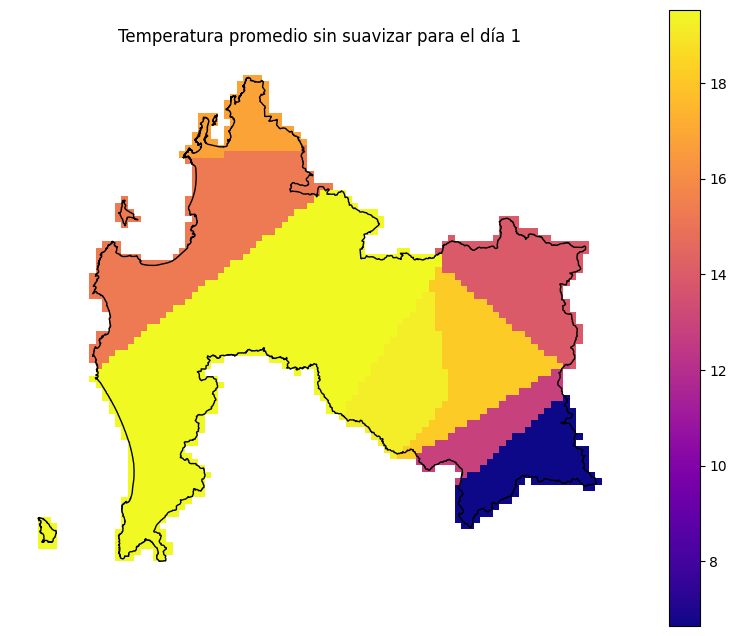

In [339]:
prueba_dia_1 = prueba[prueba['dia'] == 1]

fig, ax = plt.subplots(figsize=(10, 8))

prueba_dia_1.plot(column='t_prom', legend=True, ax = ax, cmap = 'plasma')

biobio.plot(ax=ax, color='none', edgecolor='black')

plt.title('Temperatura promedio sin suavizar para el día 1')

plt.axis('off') 

plt.show()


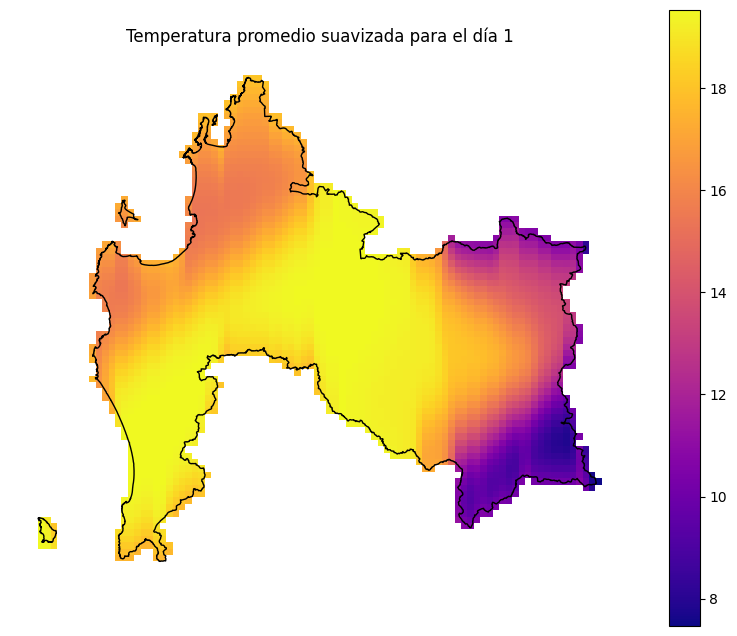

In [340]:
import pandas as pd
from scipy.ndimage import gaussian_filter1d

prueba_copy = prueba.copy()

def suavizar_columna_por_dia(df, columna_suavizar, columna_dia, sigma=5, mode='nearest'):
    dias = df[columna_dia].unique()

    for dia in dias:
        # Seleccionar solo los datos del día
        mask = df[columna_dia] == dia
        df_dia = df[mask].copy()  # Usar .copy() para asegurarse de trabajar con una copia
        # Suavizar la columna utilizando gaussian_filter1d
        df_dia[columna_suavizar] = gaussian_filter1d(df_dia[columna_suavizar], sigma=sigma, mode=mode)
        # Guardar los datos en una copia del DataFrame original
        df.loc[mask, columna_suavizar] = df_dia[columna_suavizar]
    return df

# Ejemplo de uso:
# Supongamos que tienes un DataFrame llamado 'prueba'
# suavizar_columna_por_dia(prueba, 't_prom', 'dia', sigma=5, mode='nearest')

prueba_2 = suavizar_columna_por_dia(prueba_copy, 't_prom', 'dia', sigma=5, mode='nearest')

fig, ax = plt.subplots(figsize=(10, 8))

prueba_2_dia_1 = prueba_2[prueba_2['dia'] == 1]

prueba_2_dia_1.plot(column='t_prom', ax=ax, legend=True, cmap='plasma')

biobio.plot(ax=ax, color='none', edgecolor='black')

plt.title('Temperatura promedio suavizada para el día 1')

plt.axis('off')

plt.show()

In [341]:
# exportar train y holdout como parquet
df_completo.to_parquet(r'C:\Users\joaci\OneDrive - Universidad de Chile\XII Semestre\Proyecto de ciencia de datos\Repo\Proyecto_Arauco\df_completo_3_3_final.parquet')
train.to_parquet(r'C:\Users\joaci\OneDrive - Universidad de Chile\XII Semestre\Proyecto de ciencia de datos\Repo\Proyecto_Arauco\train_3_3_final.parquet')
holdout.to_parquet(r'C:\Users\joaci\OneDrive - Universidad de Chile\XII Semestre\Proyecto de ciencia de datos\Repo\Proyecto_Arauco\holdout_3_3_final.parquet')

# 6. Agregar mes de enero genérico para predicción 2024

In [380]:
df_cuadrillas_enero = df_cuadrillas[df_cuadrillas['dia'] <= 31]

df_cuadrillas_enero

,cuadrilla,dia
0,0,1
1,0,2
2,0,3
3,0,4
4,0,5
...,...,...
1079696,2958,27
1079697,2958,28
1079698,2958,29
1079699,2958,30


## 6.1 Agregar clima

In [381]:
clima_enero = clima_dentro_region.drop(clima_dentro_region.columns[clima_dentro_region.columns < '2015-01-01'], axis=1)

# reemplazar -9999 por NaN

clima_enero = clima_enero.replace(-9999, np.nan)

# interpolacion lineal

clima_enero_var = clima_enero.iloc[:, 0:12]

clima_enero_fecha = clima_enero.iloc[:, 14:-4]

# nombre columna a datetime

clima_enero_fecha.columns = pd.to_datetime(clima_enero_fecha.columns)

# dejar solo las columnas que corresponden al mes de enero

nombres_columnas = clima_enero_fecha.columns

clima_enero_fecha = clima_enero_fecha[nombres_columnas[nombres_columnas.month == 1]]

clima_enero_coord = clima_enero.iloc[:, -2:]

clima_enero_fecha = clima_enero_fecha.interpolate(method='linear', axis=1)

# eliminar columnas con datos faltantes

clima_enero_fecha = clima_enero_fecha[clima_enero_fecha.isnull().sum(axis=1) < 10]




### 6.1.1 Crear escenarios

- Máximo: $T = \mu_{T} + \sigma_{T}$
- Promedio: $T = \mu_{T}$
- Mínimo: $T = \mu_T - \sigma_T$
- Aleatorio: $T \sim Nomal(\mu_T, \sigma_T)$

In [382]:
nombres_columnas = clima_enero_fecha.columns

# crear una funcion que obtenga las columnas correspondientes al dia X de enero y retorne un dataframe con esas columnas

def obtener_columnas_enero(dia):
    columnas = nombres_columnas[nombres_columnas.day == dia]
    return clima_enero_fecha[columnas]

obtener_columnas_enero(1)

# crear una función que retorne el promedio y la desviación estandar para cada estación para un dia X de enero

def obtener_promedio_desviacion(dia):
    columnas = nombres_columnas[nombres_columnas.day == dia]
    df = clima_enero_fecha[columnas]
    promedio = df.mean(axis=1)
    desviacion = df.std(axis=1)
    return pd.DataFrame({'promedio': promedio, 'desviacion': desviacion})

# creacion de escenarios

# a partir del promedio y la desviacion estandar, crear un escenario de temperatura para cada dia de enero

# crear una funcion que retorne un escenario de temperatura para un dia X de enero

def obtener_escenario_temperatura(dia, escenario = "promedio"):
    df = obtener_promedio_desviacion(dia)
    if escenario == "promedio":
        df['escenario'] = df['promedio']
    elif escenario == "minimo":
        df['escenario'] = df['promedio'] - df['desviacion']
    elif escenario == "maximo":
        df['escenario'] = df['promedio'] + df['desviacion']
    elif escenario == "aleatorio":
        df['escenario'] = df.apply(lambda row: np.random.normal(row['promedio'], row['desviacion']), axis=1)
    return df['escenario']

# para cada dia de enero, obtener un escenario de temperatura y guardarlo en un dataframe

escenarios_temperatura = pd.DataFrame()

for dia in range(1, 32):
    escenarios_temperatura[dia] = obtener_escenario_temperatura(dia, escenario="promedio")

### 6.1.2 Unir escenarios con estaciones

In [383]:
# hacer left join con clima_var

clima_enero = pd.concat([clima_enero_var, clima_enero_coord, escenarios_temperatura], axis=1, join='inner')

In [384]:
clima_enero.head()

,institucion,fuente,nombre,altura,codigo_cuenca,nombre_cuenca,codigo_sub_cuenca,nombre_sub_cuenca,inicio_observaciones,fin_observaciones,...,22,23,24,25,26,27,28,29,30,31
204,DGA,dga_web,Alto Mallines,1770,83,Rio Bio-Bio,837,Rio Laja Alto (Hasta Bajo Junta Rio Rucue),2002-03-23,2020-03-31,...,16.527333,15.765333,14.849833,15.301667,15.517000,15.495000,15.416833,15.484667,15.528000,16.340333
206,DGA,dga_web,Rio Huequecura Aguas Arriba De Embalse Angostura,330,83,Rio Bio-Bio,831,Rio Bio-Bio Entre Rio Ranquil Y Rio Duqueco,2013-12-23,2020-03-31,...,19.423667,18.114000,18.562667,19.405333,18.058500,18.549500,17.499833,17.668500,18.091167,17.947667
207,DGA,dga_web,Embalse Central Angostura,324,83,Rio Bio-Bio,831,Rio Bio-Bio Entre Rio Ranquil Y Rio Duqueco,2013-12-23,2020-03-31,...,20.710167,20.028667,19.715833,20.625500,20.791167,19.764500,19.277333,19.503333,19.993333,20.354000
209,DGA,dga_web,Rio Biobio En La Culebra,338,83,Rio Bio-Bio,831,Rio Bio-Bio Entre Rio Ranquil Y Rio Duqueco,2013-12-23,2020-01-27,...,19.865333,19.953000,19.420333,20.647333,19.934500,18.526500,19.659667,19.593500,19.606167,20.902167
211,DGA,dga_web,Embalse Pangue,512,83,Rio Bio-Bio,831,Rio Bio-Bio Entre Rio Ranquil Y Rio Duqueco,2014-01-01,2018-04-04,...,17.764000,18.016500,16.863167,18.075000,18.444667,17.058833,17.518333,17.714333,17.969667,18.356000


## 6.2 Agregar Precipitaciones

In [385]:
precipitaciones_enero = precipitaciones_dentro_region_2.copy()

# reemplazar -9999 por NaN

precipitaciones_enero = precipitaciones_enero.replace(-9999, np.nan)

# interpolacion lineal

precipitaciones_enero_var = precipitaciones_enero.iloc[:, 0:12]

precipitaciones_enero_fecha = precipitaciones_enero.iloc[:, 12:-4]

# nombre columna a datetime

precipitaciones_enero_fecha.columns = pd.to_datetime(precipitaciones_enero_fecha.columns)

# dejar solo las columnas que corresponden al mes de enero

nombres_columnas = precipitaciones_enero_fecha.columns

precipitaciones_enero_fecha = precipitaciones_enero_fecha[nombres_columnas[nombres_columnas.month == 1]]

precipitaciones_enero_coord = precipitaciones_enero.iloc[:, -2:]

precipitaciones_enero_fecha = precipitaciones_enero_fecha.interpolate(method='linear', axis=1)

# eliminar columnas con datos faltantes

precipitaciones_enero_fecha = precipitaciones_enero_fecha[precipitaciones_enero_fecha.isnull().sum(axis=1) < 10]


### 6.2.1 Crear escenarios

- Máximo: $P = \mu_{P} + \sigma_{P}$
- Promedio: $P = \mu_{P}$
- Mínimo: $P = \mu_P - \sigma_P$
- Aleatorio: $P \sim Nomal(\mu_P, \sigma_P)$

In [386]:
nombres_columnas = precipitaciones_enero_fecha.columns

# crear una funcion que obtenga las columnas correspondientes al dia X de enero y retorne un dataframe con esas columnas

def obtener_columnas_enero(dia):
    columnas = nombres_columnas[nombres_columnas.day == dia]
    return precipitaciones_enero_fecha[columnas]

# crear una función que retorne el promedio y la desviación estandar para cada estación para un dia X de enero

def obtener_promedio_desviacion(dia):
    columnas = nombres_columnas[nombres_columnas.day == dia]
    df = precipitaciones_enero_fecha[columnas]
    promedio = df.mean(axis=1)
    desviacion = df.std(axis=1)
    return pd.DataFrame({'promedio': promedio, 'desviacion': desviacion})

# creacion de escenarios

# a partir del promedio y la desviacion estandar, crear un escenario de temperatura para cada dia de enero

# crear una funcion que retorne un escenario de temperatura para un dia X de enero

def obtener_escenario_precipitaciones(dia, escenario = "promedio"):
    df = obtener_promedio_desviacion(dia)
    if escenario == "promedio":
        df['escenario'] = df['promedio']
    elif escenario == "minimo":
        df['escenario'] = df.apply(lambda row: max(np.random.normal(row['promedio'], row['desviacion']),0), axis=1)
    elif escenario == "maximo":
        df['escenario'] = df['promedio'] + df['desviacion']
    elif escenario == "aleatorio":
        df['escenario'] = df.apply(lambda row: max(np.random.normal(row['promedio'], row['desviacion']),0), axis=1)
    return df['escenario']

# para cada dia de enero, obtener un escenario de temperatura y guardarlo en un dataframe

escenarios_precipitaciones = pd.DataFrame()

for dia in range(1, 32):
    escenarios_precipitaciones[dia] = obtener_escenario_precipitaciones(dia, escenario="promedio")

### 6.2.2 Unir escenarios con estaciones

In [387]:
# hacer left join con clima_var

precipitaciones_enero = pd.concat([precipitaciones_enero_var, precipitaciones_enero_coord, escenarios_precipitaciones], axis=1, join='inner')

In [388]:
precipitaciones_enero.head()

,institucion,fuente,nombre,altura,codigo_cuenca,nombre_cuenca,codigo_sub_cuenca,nombre_sub_cuenca,inicio_observaciones,fin_observaciones,...,22,23,24,25,26,27,28,29,30,31
506,DGA,dga_web,Dichato,11,82,Costeras E Islas Entre Rio Itata Y Rio Bio-Bio,821,Costeras Entre Rio Pingueral Y Rio Andalien,1980-06-01,2019-03-31,...,0.0,0.000000,0.000000,0.0,0.500000,0.166667,0.0,0.0,0.0,0.0
513,DGA,dga_web,Rafael,294,81,Rio Itata,814,Itata Bajo,1993-01-01,2019-03-31,...,0.0,0.000000,0.000000,0.0,1.166667,0.000000,0.0,0.0,0.0,0.0
514,DGA,dga_web,Estero Bellavista En Tom,7,82,Costeras E Islas Entre Rio Itata Y Rio Bio-Bio,821,Costeras Entre Rio Pingueral Y Rio Andalien,2009-06-01,2020-03-31,...,0.0,0.133333,0.033333,0.0,0.683333,0.233333,0.0,0.0,0.0,0.0
523,DGA,dga_web,Las Pataguas,236,82,Costeras E Islas Entre Rio Itata Y Rio Bio-Bio,822,Rio Andalien,1993-01-01,2019-03-31,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
525,DGA,dga_web,Andalien,37,82,Costeras E Islas Entre Rio Itata Y Rio Bio-Bio,822,Rio Andalien,2000-11-01,2019-03-31,...,0.0,0.000000,0.000000,0.0,0.366667,0.000000,0.0,0.0,0.0,0.0


## 6.3 Unir todo

In [389]:
# agregar clima a df_cuadrillas_enero
df_cuadrillas_enero = df_cuadrillas[df_cuadrillas['dia'] <= 31]

# buscar el centro de cada cuadrilla y asignar latitud y longitud
df_cuadrillas_enero['x'] = df_cuadrillas_enero.apply(lambda row: cell_df.loc[row['cuadrilla'], 'geometry'].centroid.x, axis=1)
df_cuadrillas_enero['y'] = df_cuadrillas_enero.apply(lambda row: cell_df.loc[row['cuadrilla'], 'geometry'].centroid.y, axis=1)

from scipy.spatial.distance import cdist

# Supongamos que ya tienes df_cuadrillas_enero, clima_var y clima_fecha cargados

# Verifica y convierte el tipo de datos en las columnas de latitud y longitud
df_cuadrillas_enero[['x', 'y']] = df_cuadrillas_enero[['x', 'y']].astype(float)
clima_enero[['x', 'y']] = clima_enero[['x', 'y']].astype(float)

# Asegúrate de que las columnas necesarias estén presentes en ambos DataFrames
coordenadas_cuadrilla = df_cuadrillas_enero[['x', 'y']].values
coordenadas_estacion = clima_enero[['x', 'y']].values

# Calcula la matriz de distancias entre todas las cuadrículas y estaciones meteorológicas
distancias = cdist(coordenadas_cuadrilla, coordenadas_estacion)

# Encuentra el índice de la estación más cercana para cada cuadrícula
indices_estacion_cercana = np.argmin(distancias, axis=1)

# Asigna el nombre de la estación más cercana a cada cuadrícula
df_cuadrillas_enero['nombre'] = clima_enero['nombre'].iloc[indices_estacion_cercana].values

# agregar clima a df_output

df_enero = df_cuadrillas_enero.copy() # df_cuadrillas_enero es df_cuadrillas pero con los nombres ya asignados

# buscar el centro de cada cuadrilla y asignar latitud y longitud
t_prom = escenarios_temperatura.copy()

t_prom = pd.concat([clima_enero_var['nombre'], escenarios_temperatura], axis=1, join='inner')

for row in df_enero.itertuples():
    df_enero.at[row.Index, 't_prom'] = t_prom.loc[t_prom['nombre'] == row.nombre, row.dia].values[0]



C:\Users\joaci\AppData\Local\Temp\ipykernel_12128\1948079009.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cuadrillas_enero['x'] = df_cuadrillas_enero.apply(lambda row: cell_df.loc[row['cuadrilla'], 'geometry'].centroid.x, axis=1)
C:\Users\joaci\AppData\Local\Temp\ipykernel_12128\1948079009.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cuadrillas_enero['y'] = df_cuadrillas_enero.apply(lambda row: cell_df.loc[row['cuadrilla'], 'geometry'].centroid.y, axis=1)
C:\Users\joaci\AppData\Local\Tem

In [390]:
df_enero


,cuadrilla,dia,x,y,nombre,t_prom
0,0,1,592287.868735,5.745681e+06,Maria Dolores Los Angeles Ad.,19.420000
1,0,2,592287.868735,5.745681e+06,Maria Dolores Los Angeles Ad.,19.120000
2,0,3,592287.868735,5.745681e+06,Maria Dolores Los Angeles Ad.,18.916667
3,0,4,592287.868735,5.745681e+06,Maria Dolores Los Angeles Ad.,19.850000
4,0,5,592287.868735,5.745681e+06,Maria Dolores Los Angeles Ad.,19.350000
...,...,...,...,...,...,...
1079696,2958,27,853287.868735,5.775681e+06,Rio Lomin En Puente La Junta,20.961833
1079697,2958,28,853287.868735,5.775681e+06,Rio Lomin En Puente La Junta,21.201667
1079698,2958,29,853287.868735,5.775681e+06,Rio Lomin En Puente La Junta,21.617000
1079699,2958,30,853287.868735,5.775681e+06,Rio Lomin En Puente La Junta,22.033000


In [391]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist

# Supongamos que ya tienes df_cuadrillas_clima, clima_var y clima_fecha cargados

# Verifica y convierte el tipo de datos en las columnas de latitud y longitud
df_cuadrillas_enero[['x', 'y']] = df_cuadrillas_enero[['x', 'y']].astype(float)
precipitaciones_enero[['x', 'y']] = precipitaciones_enero[['x', 'y']].astype(float)

# Asegúrate de que las columnas necesarias estén presentes en ambos DataFrames
coordenadas_cuadrilla = df_cuadrillas_enero[['x', 'y']].values
coordenadas_estacion = precipitaciones_enero[['x', 'y']].values

# Calcula la matriz de distancias entre todas las cuadrículas y estaciones meteorológicas
distancias = cdist(coordenadas_cuadrilla, coordenadas_estacion)

# Encuentra el índice de la estación más cercana para cada cuadrícula
indices_estacion_cercana = np.argmin(distancias, axis=1)

# Asigna el nombre de la estación más cercana a cada cuadrícula
df_cuadrillas_enero['nombre'] = precipitaciones_enero['nombre'].iloc[indices_estacion_cercana].values

# agregar prep a df_output

df_enero_2 = df_cuadrillas_enero.copy() # df_cuadrillas_clima es df_cuadrillas pero con los nombres ya asignados

prep_prom = pd.concat([precipitaciones_enero_var['nombre'], escenarios_precipitaciones], axis=1, join='inner')

for row in df_enero_2.itertuples():
    df_enero_2.at[row.Index, 'prep_prom'] = prep_prom.loc[prep_prom['nombre'] == row.nombre, row.dia].values[0]


C:\Users\joaci\AppData\Local\Temp\ipykernel_12128\1764073648.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cuadrillas_enero[['x', 'y']] = df_cuadrillas_enero[['x', 'y']].astype(float)
C:\Users\joaci\AppData\Local\Temp\ipykernel_12128\1764073648.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cuadrillas_enero['nombre'] = precipitaciones_enero['nombre'].iloc[indices_estacion_cercana].values


In [392]:
df_enero_2

,cuadrilla,dia,x,y,nombre,prep_prom
0,0,1,592287.868735,5.745681e+06,Tirua,0.150000
1,0,2,592287.868735,5.745681e+06,Tirua,0.900000
2,0,3,592287.868735,5.745681e+06,Tirua,1.216667
3,0,4,592287.868735,5.745681e+06,Tirua,2.050000
4,0,5,592287.868735,5.745681e+06,Tirua,2.616667
...,...,...,...,...,...,...
1079696,2958,27,853287.868735,5.775681e+06,Embalse Ralco,0.166667
1079697,2958,28,853287.868735,5.775681e+06,Embalse Ralco,0.000000
1079698,2958,29,853287.868735,5.775681e+06,Embalse Ralco,0.000000
1079699,2958,30,853287.868735,5.775681e+06,Embalse Ralco,0.000000


In [393]:
# unir df_enero y df_enero_2 por cuadrilla y dia

df_enero_3 = df_enero.merge(df_enero_2, how='left', left_on=['cuadrilla', 'dia'], right_on=['cuadrilla', 'dia'])

# quitar columnas que no se necesitan

df_enero_3 = df_enero_3.drop(columns=['x_y', 'y_y', 'nombre_x', 'nombre_y'])

# renombrar columnas

df_enero_3 = df_enero_3.rename(columns={'x_x': 'x', 'y_x': 'y'})



In [394]:
df_enero_final = df_completo[df_completo['dia'] <= 31].drop(columns=['x', 'y', 't_prom', 'prep_prom', 'incendio']).merge(df_enero_3, how='left', left_on=['cuadrilla', 'dia'], right_on=['cuadrilla', 'dia'])

In [395]:
df_enero_final

,cuadrilla,dia,geometry,vegetation,bosque_nat,bosque_pro,pastizales,matorrales,humedales,cuerpos_ag,...,tierras_de,distancia_a_red_vial,distancia_a_red_hidro,distancia_a_red_electrica,distancia_a_area_urbana,altura,x,y,t_prom,prep_prom
0,0,1,"POLYGON ((593787.8687348282 5744181.299062761,...",1500,0,0,0,0,0,0,...,0,2396.263833,36622.871880,40962.548384,10123.192195,0.0,592287.868735,5.745681e+06,19.420000,0.150000
1,0,2,"POLYGON ((593787.8687348282 5744181.299062761,...",1500,0,0,0,0,0,0,...,0,2396.263833,36622.871880,40962.548384,10123.192195,0.0,592287.868735,5.745681e+06,19.120000,0.900000
2,0,3,"POLYGON ((593787.8687348282 5744181.299062761,...",1500,0,0,0,0,0,0,...,0,2396.263833,36622.871880,40962.548384,10123.192195,0.0,592287.868735,5.745681e+06,18.916667,1.216667
3,0,4,"POLYGON ((593787.8687348282 5744181.299062761,...",1500,0,0,0,0,0,0,...,0,2396.263833,36622.871880,40962.548384,10123.192195,0.0,592287.868735,5.745681e+06,19.850000,2.050000
4,0,5,"POLYGON ((593787.8687348282 5744181.299062761,...",1500,0,0,0,0,0,0,...,0,2396.263833,36622.871880,40962.548384,10123.192195,0.0,592287.868735,5.745681e+06,19.350000,2.616667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91724,2958,27,"POLYGON ((854787.8687348282 5774181.299062761,...",1500,0,0,0,0,0,0,...,0,33930.578686,2419.660524,43876.644890,100869.371519,2235.0,853287.868735,5.775681e+06,20.961833,0.166667
91725,2958,28,"POLYGON ((854787.8687348282 5774181.299062761,...",1500,0,0,0,0,0,0,...,0,33930.578686,2419.660524,43876.644890,100869.371519,2235.0,853287.868735,5.775681e+06,21.201667,0.000000
91726,2958,29,"POLYGON ((854787.8687348282 5774181.299062761,...",1500,0,0,0,0,0,0,...,0,33930.578686,2419.660524,43876.644890,100869.371519,2235.0,853287.868735,5.775681e+06,21.617000,0.000000
91727,2958,30,"POLYGON ((854787.8687348282 5774181.299062761,...",1500,0,0,0,0,0,0,...,0,33930.578686,2419.660524,43876.644890,100869.371519,2235.0,853287.868735,5.775681e+06,22.033000,0.000000


In [396]:
# exportar df_enero como parquet

df_enero_final.to_parquet(r'C:\Users\joaci\OneDrive - Universidad de Chile\XII Semestre\Proyecto de ciencia de datos\Repo\Proyecto_Arauco\df_enero_3_3_escenario_prom.parquet')

# 7. Pruebas

In [397]:
esc_fav = pd.read_parquet(r'C:\Users\joaci\OneDrive - Universidad de Chile\XII Semestre\Proyecto de ciencia de datos\Proyecto\Modelo_v4\df_enero_3_3_escenario_favorable.parquet')
esc_prom = pd.read_parquet(r'C:\Users\joaci\OneDrive - Universidad de Chile\XII Semestre\Proyecto de ciencia de datos\Proyecto\Modelo_v4\df_enero_3_3_escenario_prom.parquet')
esc_desfav = pd.read_parquet(r'C:\Users\joaci\OneDrive - Universidad de Chile\XII Semestre\Proyecto de ciencia de datos\Proyecto\Modelo_v4\df_enero_3_3_escenario_desfavorable.parquet')

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\joaci\\OneDrive - Universidad de Chile\\XII Semestre\\Proyecto de ciencia de datos\\Proyecto\\Modelo_v4\\df_enero_3_3_escenario_favorable.parquet'

In [ ]:
# transformar a geodataframe

esc_fav['geometry'] = esc_fav.apply(lambda x: Point((float(x.x), float(x.y))), axis=1)
esc_prom['geometry'] = esc_prom.apply(lambda x: Point((float(x.x), float(x.y))), axis=1)
esc_desfav['geometry'] = esc_desfav.apply(lambda x: Point((float(x.x), float(x.y))), axis=1)

esc_fav = gp.GeoDataFrame(esc_fav, geometry='geometry')
esc_prom = gp.GeoDataFrame(esc_prom, geometry='geometry')
esc_desfav = gp.GeoDataFrame(esc_desfav, geometry='geometry')


In [ ]:
# graficar

esc_fav[esc_fav['dia'] == 1].plot(column='t_prom', legend=True)

In [ ]:
holdout = pd.read_parquet(r'C:\Users\joaci\OneDrive - Universidad de Chile\XII Semestre\Proyecto de ciencia de datos\Repo\Proyecto_Arauco\holdout_3_3_final.parquet')

In [ ]:
holdout[holdout['incendio'] == 1]